# ALeRCE basics

```Authors: Alejandra Muñoz Arancibia, Francisco Förster, Lorena Hernández-García, Paula Sánchez-Sáez```

```Last updated: 250107```

ALeRCE starter notebook for supernova, variable stars and active galactic nuclei science using the new alerce client and a direct database connection. You will also use the ALeRCE DELIGHT tool to automatically identify host galaxies in SNe.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook uses the latest ALeRCE client, which can be installed with pip.

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_SN_Starter.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system. However, note that in this notebook we use ipyaladin, which does not currently work in Google Colab.

## Introduction

In this notebook we will query data from a single object, a supernova, in order to show its photometric properties and features and plot its light curve. We will also see its first image stamp, and identify the host galaxy using the ALeRCE DELIGHT tool (https://pypi.org/project/astro-delight/). Later we will query many supernovae using the ALeRCE client. We will also plot the light curve of a long period variable star to introduce apparent magnitudes obtained from difference magnitudes.

Finally, we will repeat this for a much larger sample size connecting directly to the ALeRCE database, listing the available tables and columns, doing more advanced queries like extracting features and probabilities for a large set of objects. We will also plot the light curve of a recent ZTF object including forced photometry epochs obtained from the ALeRCE database.

## Requirements

Basic requirements

In [1]:
import sys
import pandas as pd
import numpy as np

The ALeRCE client

In [2]:
#!pip install alerce

In [3]:
from alerce.core import Alerce
client = Alerce()

The ALeRCE DELIGHT client (https://pypi.org/project/astro-delight/)

WARNING: this will try to install tensorflow if you haven't installed it (pip install tensorflow). Some people report that their python distribution has problems after trying to install tensorflow.

In [4]:
#!pip install astro-delight

In [5]:
from delight.delight import Delight

2025-01-06 18:42:15.628871: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 18:42:15.651752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 18:42:15.651784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 18:42:15.652848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 18:42:15.657651: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import matplotlib.pyplot as plt

SQL queries using sqlalchemy

In [7]:
import sqlalchemy as sa

The requests library

In [8]:
import requests
import json

Visualization

In [9]:
from IPython.core.display import HTML

### Some settings

In [10]:
display(HTML('<style>.container { width:100% !important; }</style>'))

In [11]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

In [12]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6., 4.)
plt.rcParams['figure.dpi'] = 72.

## ALeRCE client starter

These are examples of very simple examples on how to interact with the ALeRCE client https://alerce.readthedocs.io/en/latest/index.html. See https://alerce.readthedocs.io/en/latest/apis.html for the API documentation.

We start the ALeRCE client

In [13]:
client = Alerce()

We will explore different methods from the client:

* Query global properties of an individual object
* Query detections of an individual object
* Query non detections of an individual object
* Query image stamps
* Query properties per band of an individual object
* Query features of an individual object
* Query probabilities of an individual object
* Query global properties of a group of objects

We will first define manually the oid that we want to explore. We will select a known supernova, you can find this object in the ALeRCE Explorer as https://alerce.online/object/ZTF20aaelulu.

In [14]:
oid = 'ZTF20aaelulu'

In [15]:
query_results = client.query_objects(oid=oid,
                                     format='pandas')
query_results

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF20aaelulu,259,792,58855.458808,58967.227049,False,False,58,0.440634,None,0.699924,None,58855.542292,58967.227049,111.684757,185.728862,15.823611,0.000021,0.000015,None,None,None,corr_bulk_0.0.1


The columns are described in here https://alerce.readthedocs.io/en/latest/models.html (same for queries below).

We use the client to query detections and non-detections (limiting magnitude) and that we return the results in pandas format (default is votable). Note that both dataframes include a unique identifier for the telescope (tid), which hints at the multi-stream nature of ALeRCE (soon to be available).


In [16]:
detections = client.query_detections(oid=oid,
                                     format='pandas')
nondetections = client.query_non_detections(oid=oid,
                                            format='pandas')
display(detections)
display(nondetections)

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magap,sigmapsf,sigmagap,ra,dec,rb,rbversion,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext
0,ztf,58855.542292,1101542291015015004,2,1101542291015,20.367030,1,1101,2.120077,17.279879,17.1583,0.056197,0.0573,185.728855,15.823626,0.832857,t17_f5_c3,1.000000,17.1147,0.0666,576120210.0,False,False,False,bulk_1.0.0,0.0,1121521071015015006,NaN,NaN,NaN
1,ztf,58859.481250,1105481241015015001,2,1105481241015,19.761808,1,1105,2.123806,14.768740,14.7860,0.032930,0.0082,185.728848,15.823626,0.812857,t17_f5_c3,0.999998,14.7761,0.0098,576120210.0,False,False,False,bulk_1.0.0,0.0,1133425771015015000,NaN,NaN,NaN
2,ztf,58859.522280,1105522281015015000,1,1105522281015,19.590542,1,1105,0.549287,14.916227,14.9567,0.028132,0.0080,185.728848,15.823617,0.858571,t17_f5_c3,0.999999,14.9805,0.0099,576120110.0,False,True,False,bulk_1.0.0,0.0,1133425771015015000,14.601364,100.00000,0.021050
3,ztf,58867.440336,1113440331015015001,1,1113440331015,20.265388,1,1113,0.499874,14.300256,14.3282,0.030383,0.0038,185.728860,15.823592,0.774286,t17_f5_c3,0.990210,14.3132,0.0043,576120110.0,False,True,False,bulk_1.0.0,0.0,1133425771015015000,14.110689,0.02116,0.025516
4,ztf,58867.481562,1113481561015015006,2,1113481561015,20.348034,1,1113,2.172854,13.859622,13.8727,0.020354,0.0034,185.728851,15.823612,0.764286,t17_f5_c3,0.999998,13.8634,0.0039,576120210.0,False,False,False,bulk_1.0.0,0.0,1133425771015015000,NaN,NaN,NaN
5,ztf,58871.442685,1117442681015015004,1,1117442681015,20.396467,1,1117,0.551084,15.030325,15.0339,0.024141,0.0065,185.728877,15.823596,0.821429,t17_f5_c3,0.999410,15.0187,0.0075,576120110.0,False,True,False,bulk_1.0.0,0.0,1133425771015015000,14.685591,100.00000,0.017573
6,ztf,58871.502234,1117502231015015005,2,1117502231015,20.242445,1,1117,2.161602,14.170009,14.1900,0.034512,0.0044,185.728848,15.823615,0.802857,t17_f5_c3,0.999988,14.1846,0.0051,576120210.0,False,False,False,bulk_1.0.0,0.0,1133425771015015000,NaN,NaN,NaN
7,ztf,58875.456991,1121456991015015006,1,1121456991015,20.504930,1,1121,0.521960,15.676039,15.6966,0.024830,0.0113,185.728861,15.823596,0.830000,t17_f5_c3,0.999950,15.6910,0.0133,576120110.0,False,True,False,bulk_1.0.0,0.0,1133425771015015000,15.114477,100.00000,0.014803
8,ztf,58875.521076,1121521071015015006,2,1121521071015,20.243944,1,1121,2.198571,14.676664,14.7027,0.024886,0.0066,185.728854,15.823604,0.775714,t17_f5_c3,0.999996,14.6939,0.0077,576120210.0,False,False,False,bulk_1.0.0,0.0,1133425771015015000,NaN,NaN,NaN
9,ztf,58878.360509,1124360501015015005,2,1124360501015,19.797495,1,1124,2.211310,15.056566,15.0541,0.023404,0.0090,185.728848,15.823600,0.620000,t17_f5_c3,0.997105,15.0152,0.0104,576120210.0,False,False,False,bulk_1.0.0,0.0,1133425771015015000,NaN,NaN,NaN


,tid,mjd,fid,diffmaglim
0,ztf,58828.547824,1,19.2005
1,ztf,58831.548472,1,19.4442
2,ztf,58833.565347,1,18.8578
3,ztf,58834.523704,2,18.8942
4,ztf,58837.462141,2,19.5815
5,ztf,58837.546817,1,19.6237
6,ztf,58838.569375,2,18.4409
7,ztf,58846.546181,1,20.4808
8,ztf,58846.567025,2,20.4058
9,ztf,58849.503183,1,20.5516


The most important columns for the detections are the time (mjd), the unique detection identifier (candid), the band (fid), the difference magnitude (magpsf) and its error (sigmapsf).

The columns for the non-detections are the time (mjd), the band (fid), and the limiting magnitude (diffmaglim).

We can also query the image stamps associated to a specific object and candid. We will use the first candid from the previously queried detections.

In [17]:
stamps = client.get_stamps(oid, detections.iloc[0].candid)

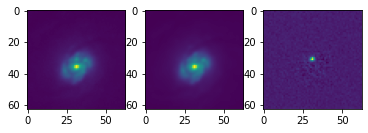

In [18]:
fig, ax = plt.subplots(ncols=3)
for i in range(3):
    ax[i].imshow(stamps[i].data)

We now query properties per band for an indivual object. You can see that the results are different statistics in two rows, one per band.

In [19]:
query_results = client.query_magstats(oid=oid,
                                      format='pandas')
query_results

,fid,stellar,corrected,ndet,ndubious,magmean,magmedian,magmax,magmin,magsigma,maglast,magfirst,firstmjd,lastmjd,step_id_corr
0,1,False,True,31,0,17.011618,16.972418,18.607530,14.300256,None,18.607530,14.916227,58859.523,58967.227,bulk_version_0.0.1
1,2,False,False,27,0,16.311693,16.427551,18.513012,13.859622,None,18.513012,17.279879,58855.543,58965.285,bulk_version_0.0.1


Now we will query the features used by our light curve classifier. These are hand made statistics or contextual information based on the object's light curve.

In [20]:
query_results = client.query_features(oid=oid,
                                      format='pandas')
query_results

,name,value,fid,version
0,gal_b,76.900066,0,lc_classifier_1.2.1-P
1,gal_l,271.133944,0,lc_classifier_1.2.1-P
2,g-r_max,0.440634,12,lc_classifier_1.2.1-P
3,g-r_mean,0.734401,12,lc_classifier_1.2.1-P
4,g-r_max_corr,NaN,12,lc_classifier_1.2.1-P
...,...,...,...,...
173,W2-W3,NaN,0,lc_classifier_1.2.1-P
174,g-W2,NaN,0,lc_classifier_1.2.1-P
175,g-W3,NaN,0,lc_classifier_1.2.1-P
176,r-W2,NaN,0,lc_classifier_1.2.1-P


You can see that there are 178 rows, where each row has a feature name (name), a value (value), a band id (fid), and a feature version (version).

A detailed explanation of all the features can be found in http://alerce.science/features/.

We can pivot these dataframe to make the features appear as columns. To do this we will add an auxiliary columns that contains the feature name and filter id all in one string, as well as adding the object identifier as a column.

In [21]:
query_results['oid'] = oid
query_results['feature'] = [f'{name}_{fid}' for name, fid \
                            in zip(query_results['name'],
                                   query_results['fid'])]

In [22]:
query_results.pivot(index='oid', columns='feature', values='value')

feature,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,Harmonics_phase_4_1,Harmonics_phase_4_2,Harmonics_phase_5_1,Harmonics_phase_5_2,Harmonics_phase_6_1,Harmonics_phase_6_2,Harmonics_phase_7_1,Harmonics_phase_7_2,IAR_phi_1,IAR_phi_2,LinearTrend_1,LinearTrend_2,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_low_1,MHPS_low_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2,MaxSlope_1,MaxSlope_2,Mean_1,Mean_2,Meanvariance_1,Meanvariance_2,MedianAbsDev_1,MedianAbsDev_2,MedianBRP_1,MedianBRP_2,Multiband_period_12,PPE_12,PairSlopeTrend_1,PairSlopeTrend_2,PercentAmplitude_1,PercentAmplitude_2,Period_band_1,Period_band_2,Power_rate_1/2_12,Power_rate_1/3_12,Power_rate_1/4_12,Power_rate_2_12,Power_rate_3_12,Power_rate_4_12,Psi_CS_1,Psi_CS_2,Psi_eta_1,Psi_eta_2,Pvar_1,Pvar_2,Q31_1,Q31_2,Rcs_1,Rcs_2,SF_ML_amplitude_1,SF_ML_amplitude_2,SF_ML_gamma_1,SF_ML_gamma_2,SPM_A_1,SPM_A_2,SPM_beta_1,SPM_beta_2,SPM_chi_1,SPM_chi_2,SPM_gamma_1,SPM_gamma_2,SPM_t0_1,SPM_t0_2,SPM_tau_fall_1,SPM_tau_fall_2,SPM_tau_rise_1,SPM_tau_rise_2,Skew_1,Skew_2,SmallKurtosis_1,SmallKurtosis_2,Std_1,Std_2,StetsonK_1,StetsonK_2,W1-W2_0,W2-W3_0,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,delta_period_1,delta_period_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,first_mag_1,first_mag_2,g-W2_0,g-W3_0,g-r_max_12,g-r_max_corr_12,g-r_mean_12,g-r_mean_corr_12,gal_b_0,gal_l_0,iqr_1,iqr_2,last_diffmaglim_before_fid_1,last_diffmaglim_before_fid_2,last_mjd_before_fid_1,last_mjd_before_fid_2,max_diffmaglim_after_fid_1,max_diffmaglim_after_fid_2,max_diffmaglim_before_fid_1,max_diffmaglim_before_fid_2,mean_mag_1,mean_mag_2,median_diffmaglim_after_fid_1,median_diffmaglim_after_fid_2,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,min_mag_1,min_mag_2,n_det_1,n_det_2,n_neg_1,n_neg_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF20aaelulu,1.997787,2.15412,0.982534,0.759591,5.0,3.0,0.37931,0.24,0.0,0.0,0.014405,0.060871,0.003784,0.004651,2.90035,2.314651,319.147506,52.653618,-1.016542,-0.41271,70601.183886,2.196005e+06,50365.208595,1.551289e+06,28169.899313,853813.765645,11962.717756,354697.132118,3638.498188,104953.070346,707.295291,19746.281716,65.933588,1775.878514,0.001071,0.0,3.141835,6.280366,0.0,6.271801,3.1429,6.254435,6.283089,6.225169,3.13487,6.181037,6.259558,6.119384,0.991631,0.964497,0.032754,0.03473,0.0,0.0,1.031099,0.858245,33.212437,30.320807,29.0,22.0,32.210728,35.328865,0.18241,0.637513,16.960974,16.226573,0.061588,0.068249,0.471397,0.502046,0.482759,0.48,296.874985,0.042345,0.533333,0.666667,0.156932,0.154523,999.999953,199.999986,0.69022,0.253076,0.237545,0.987585,0.976727,0.976727,0.356288,0.383056,0.075324,0.302232,1.0,1.0,1.08182,1.179115,0.356288,0.383056,8.962432,8.632998,0.80538,0.724913,14.343541,22.150823,0.632264,0.650254,37515.677934,41569.405337,84.064507,78.62097,-19.265086,-18.021217,52.670497,55.345033,18.535097,23.731044,-0.585384,-0.225177,0.822085,0.424437,1.044599,1.107448,0.832481,0.845904,NaN,NaN,4.307274,4.65339,107.704769,109.744398,703.124968,96.874999,5.635373,3.241921,5.233694,5.721878,14.91622

Similarly, we can query the classification probabilities for a given object.

Note that an object can be classified by different classifiers with different versions, which is shown in the columns classifier_name and classifier_version, respectively.

In [23]:
query_results = client.query_probabilities(oid=oid,
                                           format='pandas')
query_results

,classifier_name,classifier_version,class_name,probability,ranking
0,lc_classifier,hierarchical_rf_1.1.0,SNIa,0.137760,3
1,lc_classifier_periodic,hierarchical_rf_1.1.0,LPV,0.332000,1
2,lc_classifier_stochastic,hierarchical_rf_1.1.0,QSO,0.008000,4
3,lc_classifier_top,hierarchical_rf_1.1.0,Transient,0.984000,1
4,lc_classifier_transient,hierarchical_rf_1.1.0,SNIa,0.140000,3
5,stamp_classifier,stamp_classifier_1.0.0,SN,0.813201,1
6,lc_classifier,hierarchical_rf_1.1.0,SNIbc,0.525456,1
7,lc_classifier_periodic,hierarchical_rf_1.1.0,E,0.090000,5
8,lc_classifier_stochastic,hierarchical_rf_1.1.0,AGN,0.006000,5
9,lc_classifier_top,hierarchical_rf_1.1.0,Stochastic,0.006000,3


We see that we get many rows for a single object. This shows all the probabilities associated to all the ALeRCE classifiers and the classes in their associated taxonomies. The columns indicate the name of the classifier (classifier_name), its version (classifier_version), the class (class_name), the probability (probability) and the ranking (ranking) growing from most to least likely. 

Let's check the unique classifier versions associated to each classifier:

In [24]:
for clf in query_results['classifier_name'].unique():
    mask = query_results['classifier_name'] == clf
    print(clf, query_results.loc[mask]['classifier_version'].unique())

lc_classifier ['hierarchical_rf_1.1.0']
lc_classifier_periodic ['hierarchical_rf_1.1.0']
lc_classifier_stochastic ['hierarchical_rf_1.1.0']
lc_classifier_top ['hierarchical_rf_1.1.0']
lc_classifier_transient ['hierarchical_rf_1.1.0']
stamp_classifier ['stamp_classifier_1.0.0']


And now the unique classes associated to each classifier:

In [25]:
for clf in query_results['classifier_name'].unique():
    mask = query_results['classifier_name'] == clf
    print(clf, query_results.loc[mask]['class_name'].unique())

lc_classifier ['SNIa' 'SNIbc' 'SNII' 'SLSN' 'QSO' 'AGN' 'Blazar' 'CV/Nova' 'YSO' 'LPV'
 'E' 'DSCT' 'RRL' 'CEP' 'Periodic-Other']
lc_classifier_periodic ['LPV' 'E' 'DSCT' 'RRL' 'CEP' 'Periodic-Other']
lc_classifier_stochastic ['QSO' 'AGN' 'Blazar' 'CV/Nova' 'YSO']
lc_classifier_top ['Transient' 'Stochastic' 'Periodic']
lc_classifier_transient ['SNIa' 'SNIbc' 'SNII' 'SLSN']
stamp_classifier ['SN' 'AGN' 'VS' 'asteroid' 'bogus']


The classifiers are two classifiers, the `lc_classifier` and the `stamp_classifier`, where `lc_classifier` is a hierarchical classifier composed of four independent classifiers: `lc_classifier_top`, `lc_classifier_periodic`, `lc_classifier_stochastic`, and `lc_classifier_transient`. You can see more details about these classifiers in [Sánchez-Sáez+2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract) and [Carrasco-Davis+2021](https://ui.adsabs.harvard.edu/abs/2020arXiv200803309C/abstract). 

`lc_classifier`:
* AGN
* Blazar
* CEP
* CV/Nova
* DSCT
* E
* LPV
* Periodic-Other
* QSO
* RRL
* SLSN
* SNIa
* SNIbc
* SNII
* YSO

`stamp_classifier`:
* AGN
* asteroid
* bogus
* SN
* VS


`lc_classifier_top`:
* Periodic
* Stochastic
* Transient

`lc_classifier_periodic`:
* CEP
* DSCT
* E
* LPV
* Periodic-Other
* RRL

`lc_classifier_stochastic`:
* AGN
* Blazar
* CV/Nova
* QSO
* YSO

`lc_classifier_transient`:
* SLSN
* SNIa
* SNIbc
* SNII

We will now query global properties of a set of objects. In particular, we will query objects based on the most likely class.

We will query the top 250 objects classified SNII according to the light curve classifier. In here we ask for the top 200 objects in pandas format. By default this query asks for objects with classification ranking=1. We will ask for the results to be ordered by probability in descending order (DESC).

In [26]:
query_results = client.query_objects(classifier='lc_classifier',
                                     class_name='SNII',
                                     page_size=250,
                                     order_by='probability',
                                     order_mode='DESC',
                                     format='pandas')

In [27]:
query_results

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF20acknpig,80,973,59140.258160,59267.145532,False,False,78,0.209932,NaN,0.569245,NaN,59140.258160,59267.145532,126.887373,30.742865,45.020282,0.000050,0.000035,SNII,lc_classifier,0.706584,correction_0.0.1
1,ZTF21acceboj,228,1367,59473.460278,59636.135764,False,False,109,0.225803,0.576298,0.500960,0.352185,59471.461401,59636.135764,164.674363,79.087647,-13.477777,0.000017,0.000031,SNII,lc_classifier,0.702900,correction_1.0.6
2,ZTF19acytcsg,219,901,58833.436551,58980.241065,False,False,108,0.089701,NaN,0.398214,NaN,58833.436551,58980.241065,146.804514,155.119479,50.467932,0.000058,0.000027,SNII,lc_classifier,0.700596,corr_bulk_0.0.1
3,ZTF19aawgxdn,603,2769,58635.208345,58761.116354,False,False,108,0.019724,NaN,0.629673,NaN,58635.220174,58761.116354,125.896181,247.763188,41.153962,0.000026,0.000025,SNII,lc_classifier,0.699776,corr_bulk_0.0.1
4,ZTF20actkmks,142,641,59176.491505,59344.192616,False,False,63,0.168782,NaN,0.277570,NaN,59176.491505,59344.192616,167.701111,152.504302,11.916147,0.000028,0.000033,SNII,lc_classifier,0.684000,correction_0.0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,ZTF23aaoihto,220,2856,60111.472685,60294.275671,False,False,218,1.262790,NaN,1.339243,NaN,60111.472685,60294.275671,182.802986,49.879869,40.741629,0.050172,0.038013,SNII,lc_classifier,0.537096,1.2.1
246,ZTF23aasbvab,765,6350,60140.250000,60257.250000,False,False,145,0.053281,NaN,0.729744,NaN,60141.324676,60257.154340,115.829664,334.625794,29.244739,0.000036,0.000023,SNII,lc_classifier,0.536924,1.2.1
247,ZTF20aatqidk,97,692,58936.308819,59045.208218,True,False,50,0.172504,0.325034,0.448196,0.447450,58936.308819,59045.208218,108.899398,191.945948,22.286234,0.000035,0.000036,SNII,lc_classifier,0.536760,corr_bulk_0.0.1
248,ZTF19aclobbu,167,620,58788.274132,59060.451366,True,False,156,0.171263,0.251948,0.283649,0.384278,58788.274132,59060.451366,272.177234,35.772014,46.882416,0.000027,0.000025,SNII,lc_classifier,0.536568,corr_bulk_0.0.1


Note that now the columns class, classifier, and probability are included.

We will generate a link to look at all the previous objects. Here we restrict the number of objects to 200, which is the maximum number that the ALeRCE explorer can accept.

In [28]:
def print_link(index=None, classifier=None):
    expr1 = 'https://alerce.online/?oid='
    expr2 = '&oid='.join(list(index))
    expr3 = '&selectedClassifier=' + classifier + '_classifier&page=1'
    expr = expr1 + expr2 + expr3

    display(HTML("<a href='%s' target=\"_blank\"> %s <a>" % (expr, expr)))

In [29]:
print_link(index=query_results['oid'].iloc[:200], classifier='lc')

## Using DELIGHT to predict the host position

In [30]:
oid = 'ZTF20aaelulu'

In [31]:
obj = client.query_object(oid)

In [32]:
def get_host(name, ra, dec, showtable=False, doplot=False):
    dclient = Delight('./', [name], [ra], [dec])
    dclient.download()
    dclient.get_pix_coords()
    dclient.compute_multiresolution(nlevels=5, domask=False,
                                    doobject=True, doplot=False)
    dclient.load_model()
    dclient.preprocess()
    dclient.predict()
    
    if doplot:
        dclient.plot_host(name)
    if showtable:
        display(dclient.df)
    
    return dclient.df.loc[name]['ra_delight'], dclient.df.loc[name]['dec_delight']

Loading WCS information


2025-01-06 18:43:28.472224: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_16/tf.image.rot90_507/rot90/Assert/AssertGuard/branch_executed/_8


1/1 [==============================] - 2s 2s/step


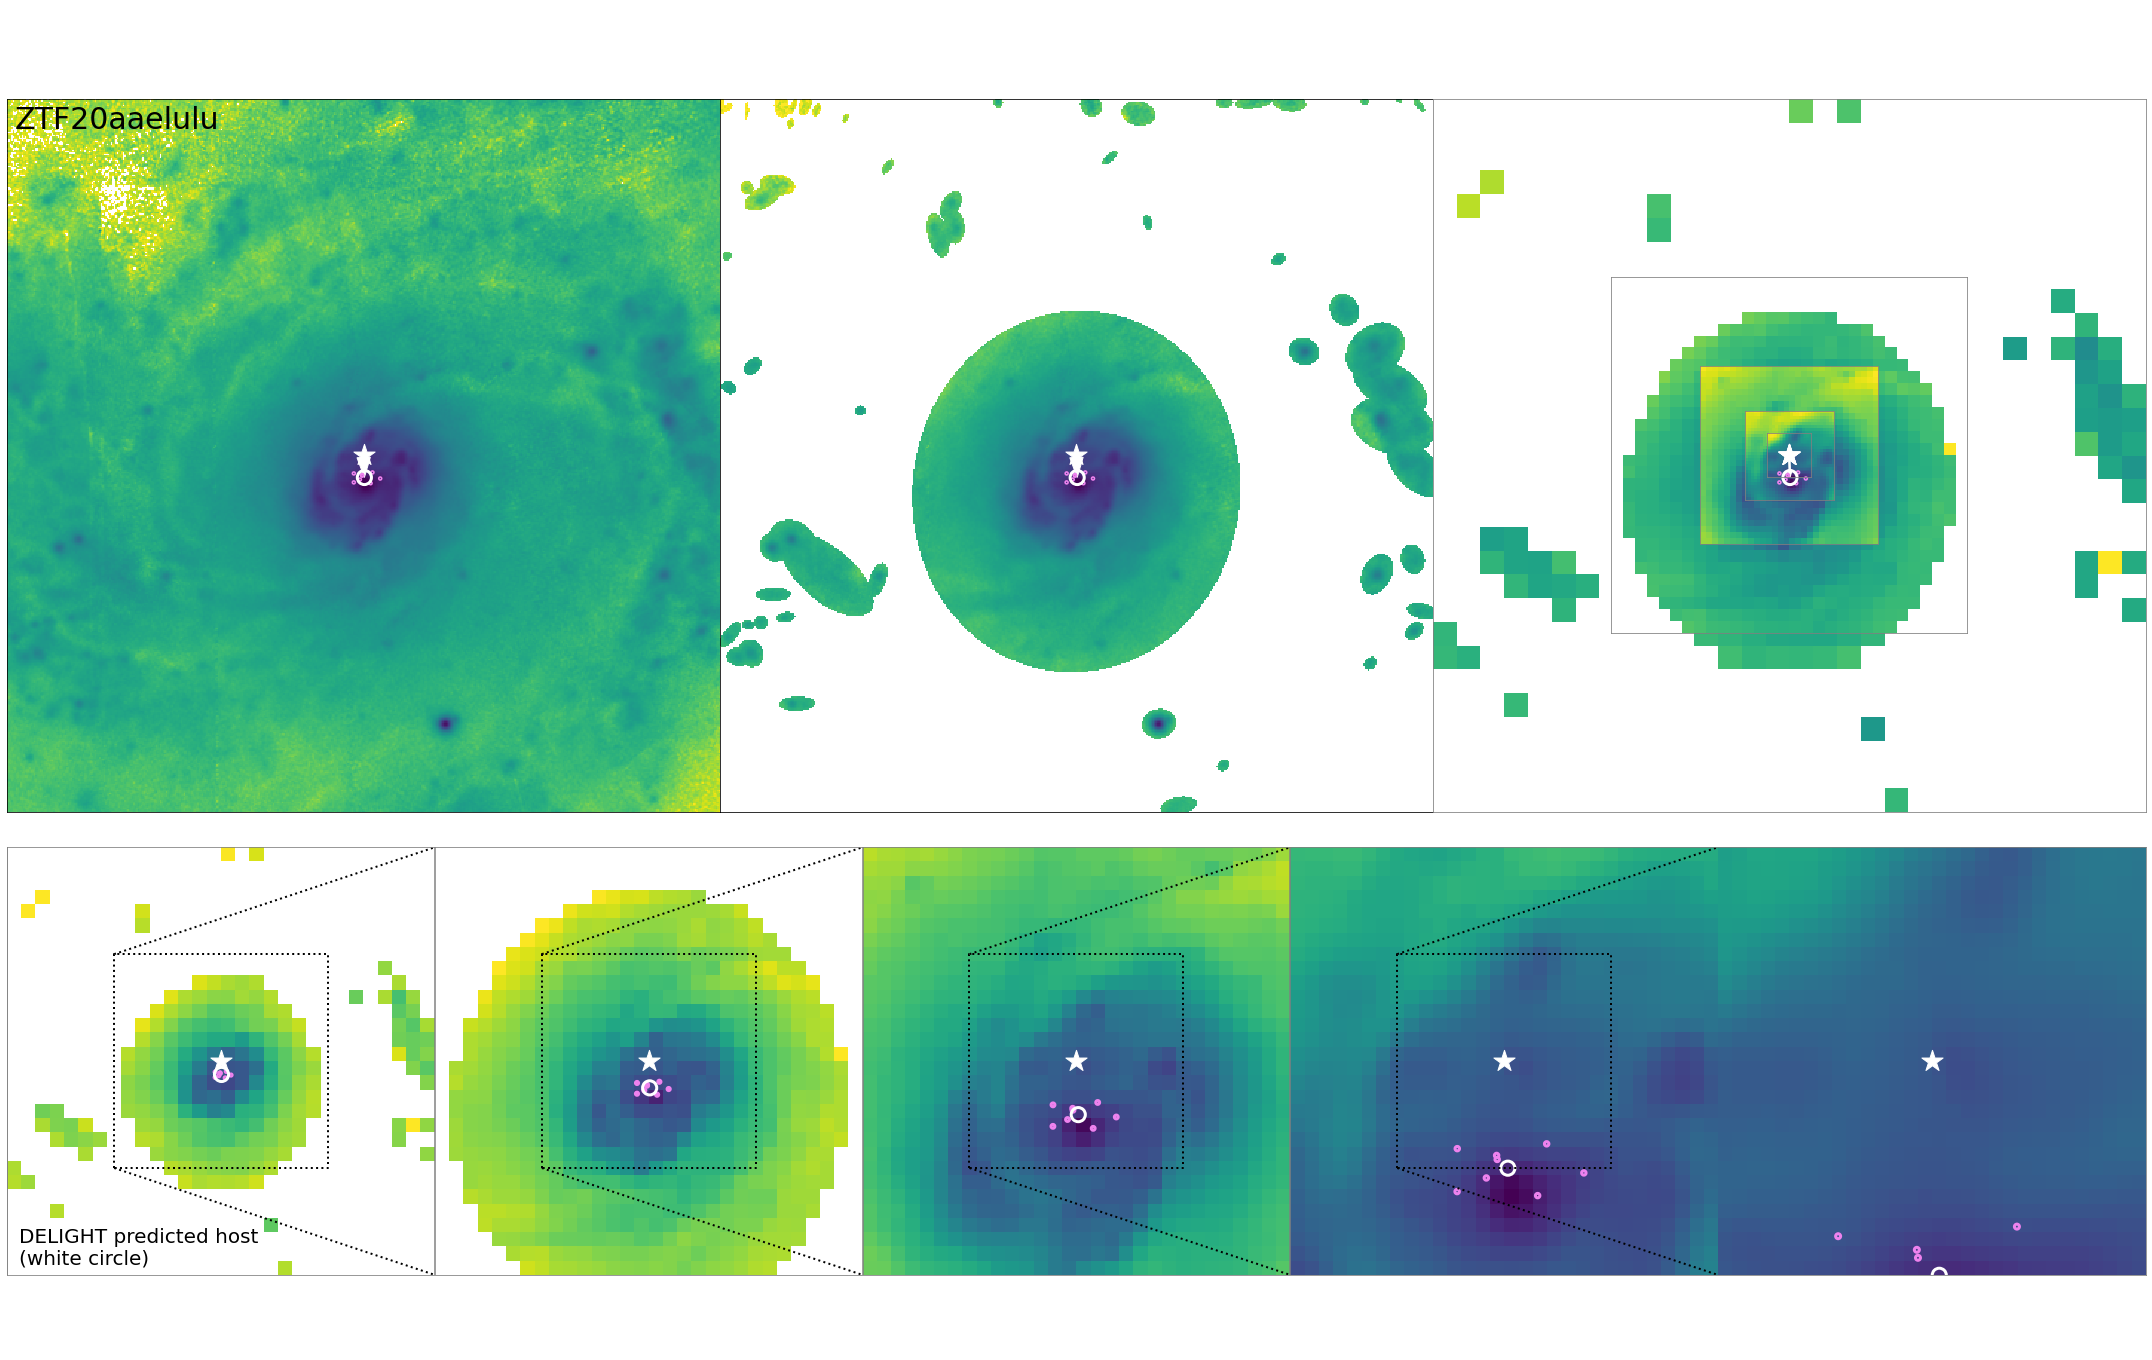

In [34]:
ra_host, dec_host = get_host(oid, obj['meanra'], obj['meandec'], doplot=True)

## Simple functions to plot light curves

We will create a simple function that plots the light curve given an object id (oid), a dataframe with detections and a dataframe with non detections. Then, we will create a function that only gets the light curve data if required, the results are then returned to the user as a dictionary.

In [35]:
def plot_diff_lc(oid, obj_det): 
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    # Loop over passbands
    for fid in [1, 2]:
        mask = obj_det.fid == fid
        if np.sum(mask) > 0:
            ax.errorbar(obj_det[mask]['mjd'], obj_det[mask]['magpsf'],
                        yerr=obj_det[mask]['sigmapsf'], c=colors[fid],
                        marker=markers[fid], label=labels[fid],
                        linestyle='None')
    
    ax.set_title(oid)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Difference magnitude')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [36]:
def get_obj_data(oid):
    results = {'oid': oid}
    
    # Query basic stats
    obj_stats = client.query_object(oid, format='pandas')
    results['stats'] = obj_stats
    
    # Query magnitude stats
    obj_magstats = client.query_magstats(oid, format='pandas')
    results['magstats'] = obj_magstats
    
    # Query detections
    obj_det = client.query_detections(oid, format='pandas')
    obj_det = obj_det.sort_values("mjd")
    results['lc_det'] = obj_det
    
    return results

In [37]:
results = get_obj_data(oid)

And now we can show the object's light curve given the unique object identifier

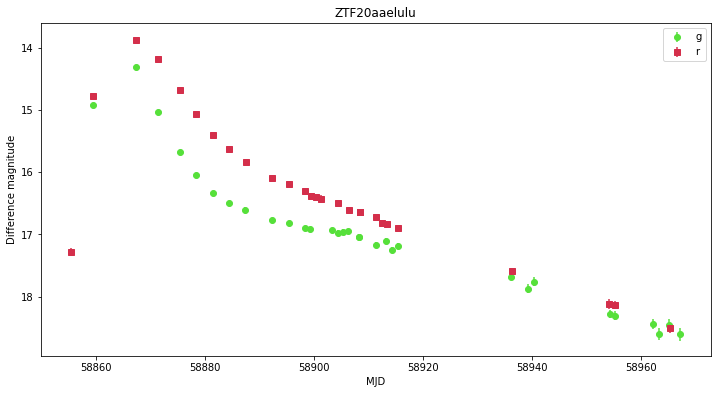

In [38]:
plot_diff_lc(oid, results['lc_det'])

ZTF detections correspond to PSF-fit magnitudes obtained from difference images (i.e. difference magnitudes). Note that for some science cases other than transients, such light curve MUST be corrected to apparent magnitudes, that is, an estimate of the science images light curve. These apparent magnitudes are computed by the ALeRCE pipeline by summing up the flux measured in the difference images ($f_{\rm diff}$) and the flux measured from the template image ($f_{\rm ref}$), taking into account whether the difference between the science and reference image in a given epoch ($\rm sgn$) is positive or negative (for more details, see the appendix A in Förster+2021):

$$
    \hat f_{\rm sci} = f_{\rm ref} + {\rm sgn}~ f_{\rm diff}
$$

We then will create a function that plots the apparent magnitude light curve.

In [39]:
def plot_app_lc(oid, obj_det):
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}
    
    for fid in [1, 2]:
        mask = (obj_det.fid == fid) & (obj_det['magpsf_corr'] != 100.)
        if np.sum(mask) > 0:
            ax.errorbar(obj_det[mask]['mjd'], obj_det[mask]['magpsf_corr'],
                        yerr=obj_det[mask].sigmapsf_corr_ext, c=colors[fid],
                        marker=markers[fid], label=labels[fid],
                        linestyle='None')
            
    ax.set_title(oid)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

For instance, we will display the difference and corrected magnitude light curves for a long period variable, ZTF18abrnhuf.

In [40]:
oid = 'ZTF18abrnhuf'

In [41]:
results = get_obj_data(oid)

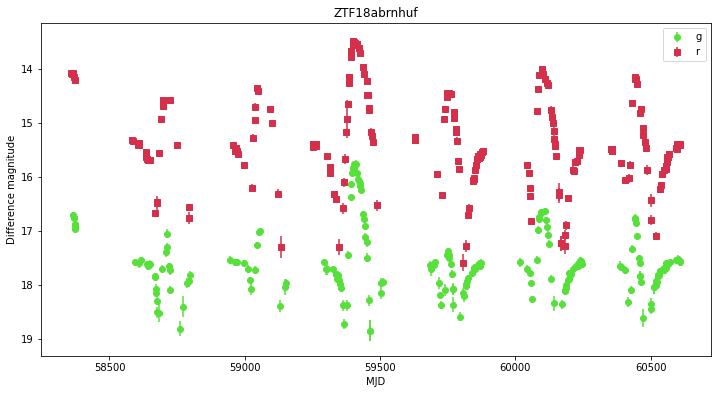

In [42]:
plot_diff_lc(oid, results['lc_det'])

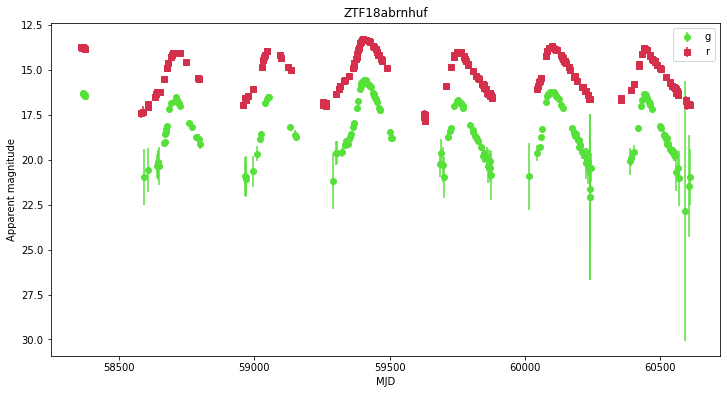

In [43]:
plot_app_lc(oid, results['lc_det'])

## Query objects using a direct DB connection

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here with different SN related use cases.

In this section you will query the tables:
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS xmatch properties (within 2")
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

You will need to use the read-only credentials available in the repository. Please be kind with the queries 😅

In [44]:
url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
params = requests.get(url).json()['params']

Now we open a connection to the DB

In [45]:
engine = sa.create_engine('postgresql+psycopg2://' + params['user'] \
                          + ':' + params['password'] + '@' + params['host'] \
                          + '/' + params['dbname'])
conn = engine.connect()

We will first show all the available tables for you to explore.

In [46]:
query = '''
SELECT
    table_name FROM information_schema.tables
WHERE
    table_schema = 'alerce'
ORDER BY table_name;
'''

tables = pd.read_sql_query(query, conn)
tables.sort_values(by='table_name')

,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,forced_photometry
6,gaia_ztf
7,lc_classifier
8,lc_classifier_periodic
9,lc_classifier_stochastic


You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `forced_photometry`: one row per forced photometry epoch, light curves and other relevant time dependent information
* `detection`: one row per detection, light curves and other relevant time dependent information
* `data_quality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables

For completeness, we now show all columns available in all tables!

In [47]:
alltabs = []

for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results['table'] = tab
    alltabs.append(results)

dftab = pd.concat(alltabs)

pd.options.display.max_rows = 999
display(dftab[['table', 'column_name', 'data_type']])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


## Light curves including ZTF forced photometry data

ZTF recently started to include PSF-fit forced photometry epochs in the public stream, back to up 30 days before a given detection. Early in December 2023 ALeRCE started to ingest these data, so we will plot light curves that include them for a recent object using the ALeRCE database. Since April 2024 you can see them in the ALeRCE Explorer too!

We create functions to convert between magnitudes and flux densities (uJy units). We follow the recommendations listed in Masci+2023 (https://arxiv.org/abs/2305.16279) sections 6.4 and 6.5 to use upper limits for low-S/N epochs.

In [48]:
def magdiff2flux_uJy(df=None, col_mag=None, col_isdiffpos='isdiffpos'):
    return 10. ** (-0.4 * (df[col_mag] - 23.9)) * df[col_isdiffpos]

In [49]:
def magtot2flux_uJy(df=None, col_mag=None):
    return 10. ** (-0.4 * (df[col_mag] - 23.9))

In [50]:
def fluxerr(df=None, col_magerr=None, col_flux=None):
    return df[col_magerr].abs() * df[col_flux].abs() / 1.0857

In [51]:
# From Masci+2023 sections 6.4 and 6.5
SNT = 3.
SNU = 5.

In [52]:
def flux_uJy2magupperlim(df=None, col_fluxerr=None):
    return -2.5 * np.log10(SNU * df[col_fluxerr].abs()) + 23.9

In [53]:
def flux_dets(df_dets):
    df = df_dets.copy()
    
    df['fluxdiff_uJy'] = magdiff2flux_uJy(df=df,
                                          col_mag='magpsf')
    df['fluxerrdiff_uJy'] = fluxerr(df=df,
                                    col_magerr='sigmapsf',
                                    col_flux='fluxdiff_uJy')
    
    if 'magpsf_corr' in df.columns:
        df['fluxtot_uJy'] = magtot2flux_uJy(df=df,
                                            col_mag='magpsf_corr')
        mask = ~df['sigmapsf_corr_ext'].isna() & ~df['sigmapsf_corr_ext'].isna()
        df.loc[mask, 'fluxerrtot_uJy'] = fluxerr(df=df[mask],
                                                 col_magerr='sigmapsf_corr_ext',
                                                 col_flux='fluxtot_uJy')
        df.loc[~mask, 'fluxerrtot_uJy'] = np.nan
    
    return df

In [54]:
def flux_forced(df_forced):
    df = df_forced.copy()
    
    df['fluxdiff_uJy_forced'] = magdiff2flux_uJy(df=df,
                                                 col_mag='mag')
    df['fluxerrdiff_uJy_forced'] = fluxerr(df=df,
                                           col_magerr='e_mag',
                                           col_flux='fluxdiff_uJy_forced')
    
    if 'mag_corr' in df.columns:
        df['fluxtot_uJy_forced'] = magtot2flux_uJy(df=df,
                                                   col_mag='mag_corr')
        mask = ~df['e_mag_corr_ext'].isna() & ~df['fluxtot_uJy_forced'].isna()
        df.loc[mask, 'fluxerrtot_uJy_forced'] = fluxerr(df=df[mask],
                                                        col_magerr='e_mag_corr_ext',
                                                        col_flux='fluxtot_uJy_forced')
        df.loc[~mask, 'fluxerrtot_uJy_forced'] = np.nan
    
    return df

In [55]:
def plot_lc(df_dets=None, df_nondets=None, df_forced=None,
            use_diff=False, use_flux=False, title=''):
    fids = [1, 2]#, 3]
    
    labels_ztfa = {1: 'ZTF_g', 2: 'ZTF_r'}
    colors_ztfa = {1: '#56E03A', 2: '#D42F4B'}
    markers_ztfa = {1: 'o', 2: 's'}
    sizes_ztfa = {1: 60, 2: 60}
    
    labels_ztffp = {1: 'ZTF_g', 2: 'ZTF_r'}
    colors_ztffp = {1: 'mediumseagreen', 2: 'firebrick'}
    markers_ztffp = {1: 'o', 2: 's'}
    sizes_ztffp = {1: 30, 2: 30}
    
    alpha_dets = 0.7
    alpha_nondets = 0.5
    alpha_forced = 0.6
    
    size_nondets = 35
    size_forced_uplim = 20
    
    if df_dets is not None:
        df_dets = df_dets.copy()
        
        if not use_diff and 'magpsf_corr' in df_dets.columns:
            mask = (df_dets['magpsf_corr'] < 99.) \
                   & (df_dets['sigmapsf_corr_ext'] < 99.)
            df_dets = df_dets[mask].copy()
    
    if df_forced is not None:
        df_forced = df_forced.copy()
        
        if use_diff:
            mask = (df_forced['mag'] < 99.)# \
                   #& (df_forced['e_mag'].abs() < 1.)
            df_forced = df_forced[mask].copy()
        else:
            if 'mag_corr' in df_forced.columns:
                mask = (df_forced['mag_corr'] < 99.)# \
                       #& (df_forced['e_mag_corr_ext'].abs() < 1.)
                df_forced = df_forced[mask].copy()
    
    if not use_diff and len(df_dets) == 0 and len(df_forced) == 0:
        exts = oid + ' has no data to display in'
        
        if use_flux:
            print(exts + ' total flux')
        else:
            print(exts + ' apparent magnitude')
        
        return
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.set_title(title)
    
    col_x = 'mjd'
    
    if df_dets is not None:
        if not use_diff and 'magpsf_corr' not in df_dets.columns:
            pass
        
        if use_flux:
            if use_diff:
                col_y = 'fluxdiff_uJy'
                col_yerr = 'fluxerrdiff_uJy'
            else:
                col_y = 'fluxtot_uJy'
                col_yerr = 'fluxerrtot_uJy'
        else:
            if use_diff:
                col_y = 'magpsf'
                col_yerr = 'sigmapsf'
            else:
                col_y = 'magpsf_corr'
                col_yerr = 'sigmapsf_corr_ext'
        
        for fid in fids:
            mask = df_dets['fid'] == fid
            if len(df_dets[col_y][mask].notna()) > 0:
                ax.errorbar(df_dets[col_x][mask],
                            df_dets[col_y][mask],
                            yerr=df_dets[col_yerr][mask],
                            alpha=alpha_dets, c=colors_ztfa[fid],
                            linestyle='None')
                ax.scatter(df_dets[col_x][mask],
                           df_dets[col_y][mask],
                           alpha=alpha_dets,
                           s=sizes_ztfa[fid],
                           c=colors_ztfa[fid],
                           marker=markers_ztfa[fid],
                           label='%s (detection)' % labels_ztfa[fid],
                           linestyle='None')
    
    if df_nondets is not None and use_diff and not use_flux:
        for fid in fids:
            mask = df_nondets['fid'] == fid
            if len(df_nondets[mask]) > 0:
                ax.scatter(df_nondets[col_x][mask],
                           df_nondets['diffmaglim'][mask],
                           alpha=alpha_nondets,
                           s=size_nondets,
                           c=colors_ztfa[fid],
                           marker='v',
                           label='%s (non-detection)' % labels_ztfa[fid],
                           linestyle='None')
    
    if df_forced is not None:
        if not use_diff and 'mag_corr' not in df_forced.columns:
            pass
        
        if use_flux:
            if use_diff:
                col_y = 'fluxdiff_uJy_forced'
                col_yerr = 'fluxerrdiff_uJy_forced'
            else:
                col_y = 'fluxtot_uJy_forced'
                col_yerr = 'fluxerrtot_uJy_forced'
        else:
            if use_diff:
                col_y = 'mag'
                col_yerr = 'e_mag'
                
                mask_snt = df_forced['fluxdiff_uJy_forced'] \
                           / df_forced['fluxerrdiff_uJy_forced'] > SNT
                col_fluxerr = 'fluxerrdiff_uJy_forced'
            else:
                col_y = 'mag_corr'
                col_yerr = 'e_mag_corr_ext'
                
                mask_snt = df_forced['fluxtot_uJy_forced'] \
                           / df_forced['fluxerrtot_uJy_forced'] > SNT
                col_fluxerr = 'fluxerrtot_uJy_forced'
            
            df_forced_uplim = df_forced[~mask_snt].copy()
            df_forced_uplim[col_y + '_upperlimit'] = flux_uJy2magupperlim(df=df_forced_uplim,
                                                                          col_fluxerr=col_fluxerr)
            
            df_forced = df_forced[mask_snt].copy()
        
        for fid in fids:
            mask = df_forced['fid'] == fid
            if len(df_forced[col_y][mask].notna()) > 0:
                ax.errorbar(df_forced[col_x][mask],
                            df_forced[col_y][mask],
                            yerr=df_forced[col_yerr][mask],
                            alpha=alpha_forced, c=colors_ztffp[fid],
                            linestyle='None')
                ax.scatter(df_forced[col_x][mask],
                           df_forced[col_y][mask],
                           alpha=alpha_forced,
                           s=sizes_ztffp[fid],
                           c='none',
                           edgecolor=colors_ztffp[fid],
                           marker=markers_ztffp[fid],
                           label='%s (forced)' % labels_ztffp[fid],
                           linestyle='None')
            
        if not use_flux and len(df_forced_uplim) > 0:
            for fid in fids:
                mask = df_forced_uplim['fid'] == fid
                if len(df_forced_uplim[mask]) > 0:
                    ax.scatter(df_forced_uplim[col_x][mask],
                               df_forced_uplim[col_y + '_upperlimit'][mask],
                               alpha=alpha_forced,
                               s=size_forced_uplim,
                               c='none',
                               edgecolor=colors_ztffp[fid],
                               marker='v',
                               label='%s (forced, upper limit)' % labels_ztffp[fid],
                               linestyle='None')
    
    ax.set_xlabel('Modified Julian Date')
    
    if use_flux:
        if use_diff:
            ax.set_ylabel('Difference Flux [uJy]')
        else:
            ax.set_ylabel('Total Flux [uJy]')
    else:
        if use_diff:
            ax.set_ylabel('Difference Magnitude')
            ax.set_ylim(ax.get_ylim()[::-1])
        else:
            ax.set_ylabel('Apparent Magnitude')
            ax.set_ylim(ax.get_ylim()[::-1])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We create a function that only gets the light curve data if required, using the database

In [56]:
def get_obj_dbdata(names):
    query = '''
    SELECT
        *
    FROM
        detection
    WHERE
        oid IN (%s)
    ''' % (','.join(["'%s'" % oid for oid in names]))
    
    df_dets = pd.read_sql_query(query, conn)
    #display(df_dets)
    
    query = '''
    SELECT
        *
    FROM
        non_detection
    WHERE
        oid IN (%s)
    ''' % (','.join(["'%s'" % oid for oid in names]))
    
    df_nondets = pd.read_sql_query(query, conn)
    #display(df_nondets)
    
    query = '''
    SELECT
        *
    FROM
        forced_photometry
    WHERE
        oid IN (%s)
    ''' % (','.join(["'%s'" % oid for oid in names]))
    
    df_forced = pd.read_sql_query(query, conn)
    #display(df_forced)
    
    return df_dets, df_nondets, df_forced

We now select the object, obtain its data and display its light curves using both magnitudes and flux densities, as both difference and apparent values.

In [57]:
names = ['ZTF23abrylud']

df_dets, df_nondets, df_forced = get_obj_dbdata(names)

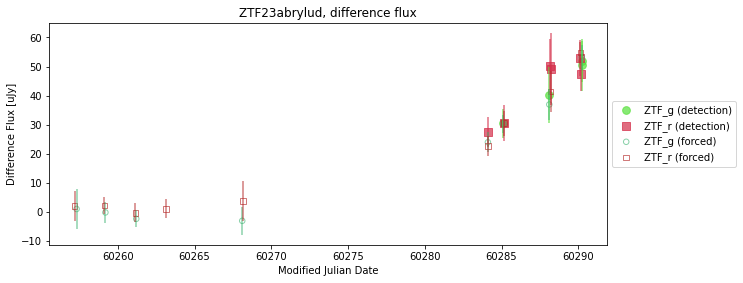

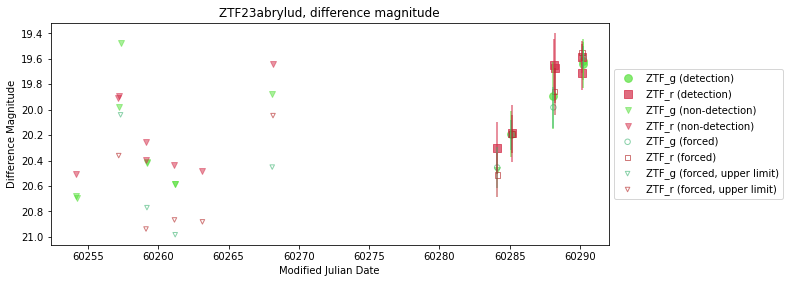

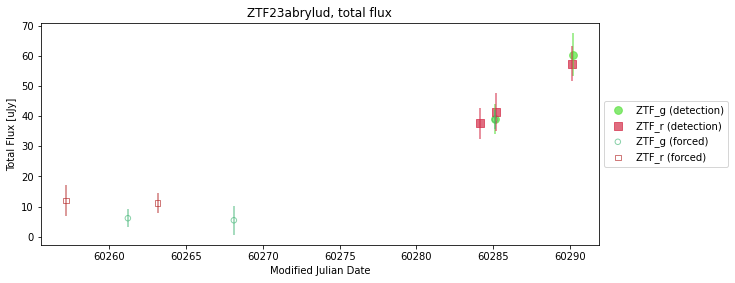

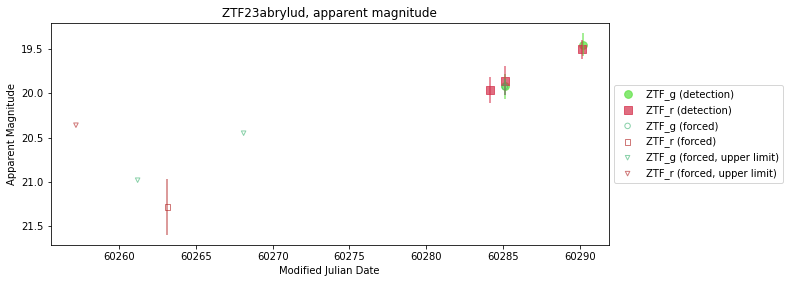

In [58]:
for i, oid in enumerate(names):
    #print(oid)
        
    if len(df_dets) == 0 and len(df_nondets) == 0 and len(df_forced) == 0:
        continue
    
    df_dets_aux = df_dets[df_dets['oid'] == oid].copy()
    df_nondets_aux = df_nondets[df_nondets['oid'] == oid].copy()
    df_forced_aux = df_forced[df_forced['oid'] == oid].copy()
    
    df_dets_aux = flux_dets(df_dets_aux)
    df_forced_aux = flux_forced(df_forced_aux)
    
    if len(df_dets_aux) == 0 and (len(df_nondets_aux) == 0)\
    and len(df_forced_aux == 0):
        print('No epochs available for oid=' + oid)
        continue
    
    plot_lc(df_dets=df_dets_aux,
            df_nondets=df_nondets_aux,
            df_forced=df_forced_aux,
            title=oid + ', difference flux',
            use_diff=True, use_flux=True)
    
    plot_lc(df_dets=df_dets_aux,
            df_nondets=df_nondets_aux,
            df_forced=df_forced_aux,
            title=oid + ', difference magnitude',
            use_diff=True)
        
    plot_lc(df_dets=df_dets_aux,
            df_nondets=df_nondets_aux,
            df_forced=df_forced_aux,
            title=oid + ', total flux',
            use_flux=True)
        
    plot_lc(df_dets=df_dets_aux,
            df_nondets=df_nondets_aux,
            df_forced=df_forced_aux,
            title=oid + ', apparent magnitude')

## Query many AGN, QSO, and Blazar candidates using a direct DB connection

Using the ALeRCE client for querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here.

Now we can do a query asking for sources classfied as AGN, QSO or Blazar. We define a minimum number of detections (ndet), and a minimum time span between the first and the last detection (deltajd), in order to ensure the detection of a variable signal from the light curves. We also filter out sources by their predicted class probability. The DB includes a larger number of QSO and AGN than Blazars, so to be able to collect similar numbers, we include a UNION in this query. WARNING: this might take some time to run depending on the selection criteria...

In [59]:
query = '''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_mean_corr,
    probability_oid.classifier_name, probability_oid.class_name,
    probability_oid.ranking, probability_oid.probability
FROM
    object INNER JOIN (
    SELECT
        oid, classifier_name, class_name, ranking, probability
    FROM
        probability
    WHERE
        classifier_name = 'lc_classifier'
        AND class_name IN ('AGN', 'QSO')
        AND ranking = 1
        AND probability > 0.95
    UNION
    SELECT
        oid, classifier_name, class_name, ranking, probability
    FROM
        probability
    WHERE
        classifier_name = 'lc_classifier'
        AND class_name IN ('Blazar')
        AND ranking = 1
        AND probability > 0.8
    ) AS probability_oid
    ON object.oid = probability_oid.oid
WHERE
    probability_oid.classifier_name = 'lc_classifier'
    AND object.deltajd > 200
    AND object.ndet > 40
'''

objects = pd.read_sql_query(query, conn)
print(objects.shape)
objects.set_index('oid', inplace=True)
objects.head()

(962, 11)


,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF18aabyvkm,140.439081,23.596725,470,58388.531262,2292.801018,NaN,lc_classifier,Blazar,1,0.845824
ZTF18ablmomq,218.203223,50.180172,124,58334.183021,2139.137801,0.156469,lc_classifier,QSO,1,0.958000
ZTF19aaokjmz,231.173387,15.355841,462,58547.416574,2134.160521,NaN,lc_classifier,Blazar,1,0.817656
ZTF20abjziki,219.179109,23.445758,153,59012.194155,1663.325822,NaN,lc_classifier,QSO,1,0.956000
ZTF18aaaxler,128.096731,49.222500,598,58366.505012,2307.764560,NaN,lc_classifier,Blazar,1,0.832728


How many sources are classified as QSOs, AGNs or Blazars?

In [60]:
print('QSO: ', len(objects.loc[objects['class_name'] == 'QSO']))
print('AGN: ', len(objects.loc[objects['class_name'] == 'AGN']))
print('Blazar: ', len(objects.loc[objects['class_name'] == 'Blazar']))

QSO:  570
AGN:  111
Blazar:  281


In [61]:
oids_objects = objects.index.values

We query some relevant features for active galaxies from the feature table, like the MHPS features. These features are described in detail in Sánchez-Sáez+2021. Note that these features are computed using the observer-frame light curves (i.e., the light curves are not corrected by redshift). WARNING: this might take some time to run...

In [62]:
query='''
SELECT
    *
FROM
    feature
WHERE
     LEFT(name, 4) = 'MHPS'
     AND oid in (%s)
''' % ','.join(["'%s'" % oid for oid in oids_objects])

features = pd.read_sql_query(query, conn)
features.head()

,oid,name,value,fid,version
0,ZTF17aaachjt,MHPS_ratio,122.180946,1,lc_classifier_1.2.1-P
1,ZTF17aaachjt,MHPS_low,0.785796,1,lc_classifier_1.2.1-P
2,ZTF17aaachjt,MHPS_high,0.006431,1,lc_classifier_1.2.1-P
3,ZTF17aaachjt,MHPS_non_zero,41.000000,1,lc_classifier_1.2.1-P
4,ZTF17aaachjt,MHPS_PN_flag,0.000000,1,lc_classifier_1.2.1-P


Let's save these features in a new dataframe to make their manipulation easier 

In [63]:
features['fname'] = features.name + '_' + features.fid.astype(str)
features_aux = features.pivot_table(index='oid', columns='fname',
                                    values='value')
features_aux.head()

fname,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_high_30_1,MHPS_high_30_2,MHPS_low_1,MHPS_low_2,MHPS_low_365_1,MHPS_low_365_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2,MHPS_ratio_365_30_1,MHPS_ratio_365_30_2
oid,,,,,,,,,,,,,,,,
ZTF17aaachjt,0.250000,0.125000,0.055961,0.095767,NaN,NaN,3.905334,3.445390,NaN,NaN,56.375000,79.500000,73.821435,93.288799,NaN,NaN
ZTF17aaaivav,0.214286,0.142857,0.111790,0.050080,0.274173,0.265385,2.602735,2.391537,4.118860,1.338108,189.285714,330.285714,24.418371,53.386222,15.023074,5.042194
ZTF17aaakeyg,0.000000,1.000000,0.001447,0.012669,0.222315,0.239302,0.346982,0.419597,1.200689,0.447707,101.153846,35.076923,231.781540,32.220612,5.402112,1.870885
ZTF17aaapjmw,0.000000,0.000000,1.816152,1.091945,21.979590,6.744296,50.254162,32.119001,192.367020,276.731491,117.600000,176.700000,544.879951,56.422997,8.752334,41.031910
ZTF17aabtnzx,0.125000,0.000000,0.385298,0.176753,5.570924,0.994601,23.058358,2.341409,141.449593,26.400255,141.750000,188.000000,78.539950,48.461890,25.355666,26.543560


In [64]:
objects = objects.join(features_aux)
objects.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,class_name,ranking,probability,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_high_30_1,MHPS_high_30_2,MHPS_low_1,MHPS_low_2,MHPS_low_365_1,MHPS_low_365_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2,MHPS_ratio_365_30_1,MHPS_ratio_365_30_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF18aabyvkm,140.439081,23.596725,470,58388.531262,2292.801018,NaN,lc_classifier,Blazar,1,0.845824,0.0,0.111111,0.009418,0.100338,0.176975,2.138738,0.659789,12.383021,8.062498,42.767881,143.111111,172.444444,76.771243,14795.095259,45.555529,19.996392
ZTF18ablmomq,218.203223,50.180172,124,58334.183021,2139.137801,0.156469,lc_classifier,QSO,1,0.958000,1.0,1.000000,0.005280,0.004556,NaN,NaN,0.008196,0.002989,NaN,NaN,20.333333,21.000000,1.342437,0.770950,NaN,NaN
ZTF19aaokjmz,231.173387,15.355841,462,58547.416574,2134.160521,NaN,lc_classifier,Blazar,1,0.817656,0.1,0.090909,18.710223,2.448273,223.892044,29.859179,213.690906,29.000938,3041.698486,201.244751,161.800000,136.727273,13.199513,-433.580017,13.585559,6.739795
ZTF20abjziki,219.179109,23.445758,153,59012.194155,1663.325822,NaN,lc_classifier,QSO,1,0.956000,1.0,1.000000,0.009015,0.008788,0.032580,0.010458,0.083458,0.020802,1.115071,0.665714,44.200000,28.750000,14.619761,2.338656,34.225250,63.657513
ZTF18aaaxler,128.096731,49.222500,598,58366.505012,2307.764560,NaN,lc_classifier,Blazar,1,0.832728,0.0,0.000000,0.043139,0.044223,0.419262,0.502132,1.020493,5.131751,8.238054,9.507848,201.333333,207.000000,24.042974,453.765943,19.649032,18.940938


Let's see the distribution of these features. We will plot the distribution of the Mexican Hat Power Spectrum (MHPS) features. These features are based on the method presented in [Arévalo+2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.426.1793A/abstract). They proposed a method to compute low-resolution power spectra from data with gaps, where the light curves are convolved with a Mexican hat filter. This method can be used to isolate structures  with a characteristic timescale in a given light curve, in order to estimate the light curve normalized variance associated with that timescale. We compute the light curve variance at two different timescales of 10 (high frequency; MHPS\_high) and 100 days (low frequency; MHPS\_low). We also compute the ratio between the low and high frequency variances for a given band, denoted as MHPS\_ratio. The logarithm of MHPS\_ratio is therefore an estimate of the power law slope of the power spectrum of the light curve.

Below we plot the distribution of these features for the $g$ (\_1) and $r$ band (\_2)

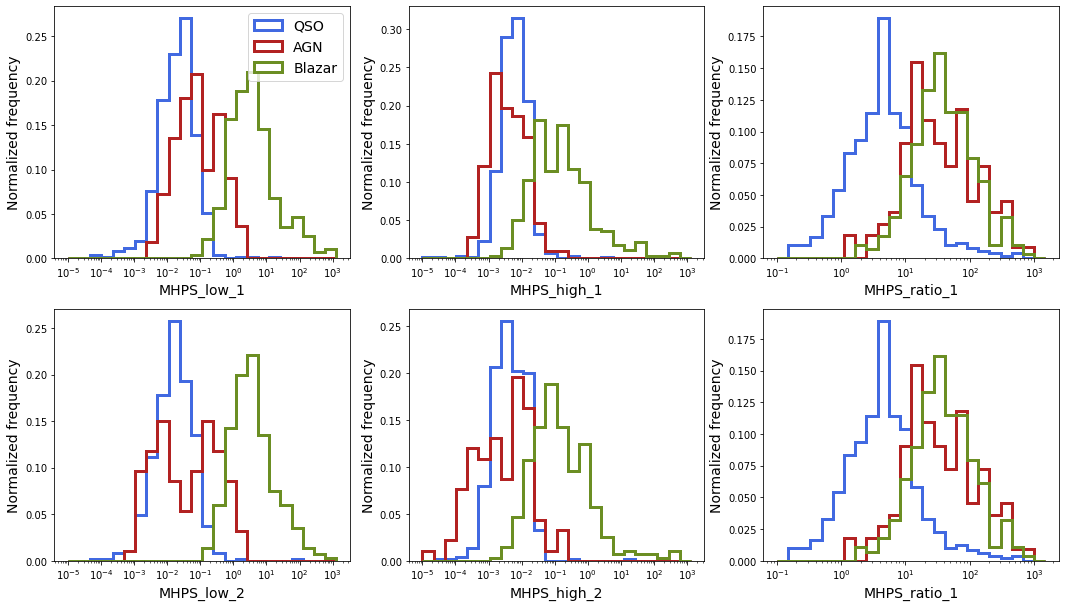

In [65]:
fig, ax = plt.subplots(nrows=2, ncols= 3, figsize = (18,10)) 

for feature, axr, axc in [("MHPS_low_1", 0, 0), ("MHPS_high_1", 0, 1),
                         ("MHPS_ratio_1", 0, 2), ("MHPS_low_2", 1, 0),
                         ("MHPS_high_2", 1, 1), ("MHPS_ratio_1", 1, 2)]:
    if feature == "MHPS_ratio_1" or feature == "MHPS_ratio_2":
        bins_hist = np.logspace(np.log10(1e-1),
                                np.log10(1500), 25,
                                base=10.0, endpoint=True)
    else:
        bins_hist = np.logspace(np.log10(1e-5),
                                np.log10(1300), 25,
                                base=10.0, endpoint=True)
    
    objects_aux = objects[objects[feature] >= np.min(bins_hist)]
    for class_name, color in [("QSO", "royalblue"),
                              ("AGN", "firebrick"),
                              ("Blazar", "olivedrab")]:
        weights = np.ones_like(
            objects_aux.loc[objects_aux["class_name"] == class_name,
                            feature].values) \
            / float(len(objects_aux.loc[objects_aux["class_name"] == class_name,
                                        feature].values))
        ax[axr, axc].hist(objects_aux.loc[objects_aux["class_name"] == class_name,
                                          feature].values,
                          weights=weights, cumulative=False, stacked=False, 
                          density=False, histtype='step', bins=bins_hist, lw=3,
                          color=color, ec=color, label=class_name, alpha=1.0)
    
    ax[axr,axc].set_xlabel(feature, fontsize=14)
    ax[axr,axc].set_ylabel('Normalized frequency', fontsize=14)
    ax[axr,axc].set_xscale('log')

ax[0, 0].legend(loc='upper right', fontsize=14);

It can be seen that in general, the power law slope of the power spectrum of QSO is smaller. 

### Close the connection

In [66]:
conn.close()

**Congratulations, you made it to the end of this notebook!**

**If you would like to contribute to our repository with your own notebook, please let us know!**